In [1]:
from pathlib import Path
import datetime
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from google.cloud import bigquery
import db_dtypes

# Import Dataset

#### a) From locally stored CSV dataset

In [2]:
df = pd.read_csv('../data/raw/train_1.csv', index_col=None)
df.columns = map(str.lower, df.columns) # make column names lowercase

In [3]:
# Melt the DataFrame to a long format
df = df.melt(id_vars=['page'], var_name='date', value_name='traffic')

#### b) From BigQuery

If running directly on GCP

In [ ]:
%%bigquery df
SELECT
  page,
  date,
  traffic
FROM
  web_traffic_dataset.web_traffic_tb

Otherwise, if running locally

In [ ]:
# Initialize a BigQuery client
project_id = 'web-traffic-time-series'

client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT
  page,
  date,
  traffic
FROM
  web_traffic_dataset.web_traffic_tb
"""

df = client.query(query).to_dataframe()

## First Inspection

In [ ]:
df["date"] = pd.to_datetime(df["date"])

In [ ]:
df.info()

In [ ]:
df.sample(5)

# Missing Values

Since the data source for this dataset does not distinguish between traffic values of zero and missing values (a missing value may mean the traffic was zero or that the data is not available for that day), for simplicity missing values are replaced with a null traffic. Another solution can be linear interpolation.

In [4]:
df = df.fillna(0)

# Language Analysis

**Extract the page language**

In [5]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'NA'

df['language'] = df.page.map(get_language)

In [6]:
df.sample(3)

,page,date,traffic,language
17132679,MediaWiki:TextCleaner.js_commons.wikimedia.org...,2015-10-27,1.0,NA
57515067,Incoterm_es.wikipedia.org_desktop_all-agents,2016-07-31,232.0,es
58420052,БРИКС_ru.wikipedia.org_desktop_all-agents,2016-08-06,378.0,ru


**Number of Pages per Language**

In [42]:
df_language_npages = df.groupby('language')['traffic'].agg('count').reset_index()

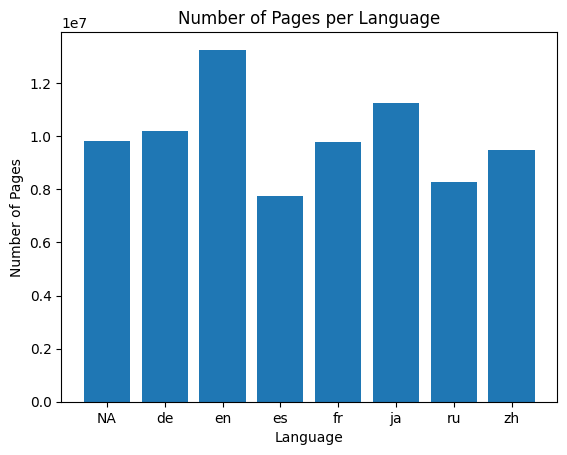

In [45]:
# Sort the DataFrame by language alphabetically
df_language_npages = df_language_npages.sort_values('language')

# Create the bar plot
plt.bar(df_language_npages['language'], df_language_npages['traffic'])
plt.xlabel('Language')
plt.ylabel('Number of Pages')
plt.title('Number of Pages per Language')

plt.show()

**Average Language Traffic**

In [39]:
df_language_avg_traffic = df.groupby('language')['traffic'].agg('mean').reset_index()

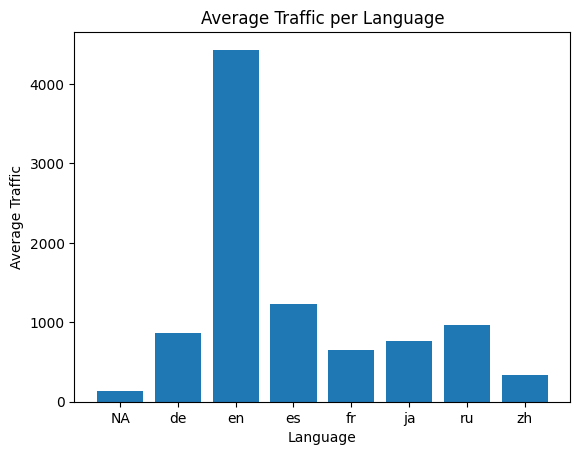

In [41]:
# Sort the DataFrame by language alphabetically
df_language_avg_traffic = df_language_avg_traffic.sort_values('language')

# Create the bar plot
plt.bar(df_language_avg_traffic['language'], df_language_avg_traffic['traffic'])
plt.xlabel('Language')
plt.ylabel('Average Traffic')
plt.title('Average Traffic per Language')
plt.show()

**Total Language Traffic**

In [46]:
df_language_total_traffic = df.groupby('language')['traffic'].agg('sum').reset_index()

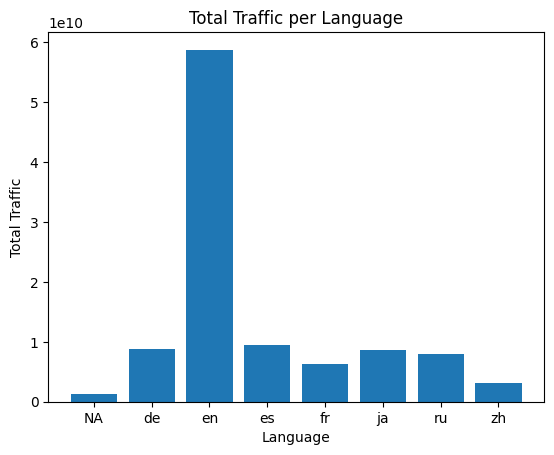

In [47]:
# Sort the DataFrame by language alphabetically
df_language_total_traffic = df_language_total_traffic.sort_values('language')

# Create the bar plot
plt.bar(df_language_total_traffic['language'], df_language_total_traffic['traffic'])
plt.xlabel('Language')
plt.ylabel('Total Traffic')
plt.title('Total Traffic per Language')
plt.show()

**Language Time Series**

In [24]:
df_language_tot_traffic = df.groupby(['date', 'language'])['traffic'].sum().unstack()

Plot language time series

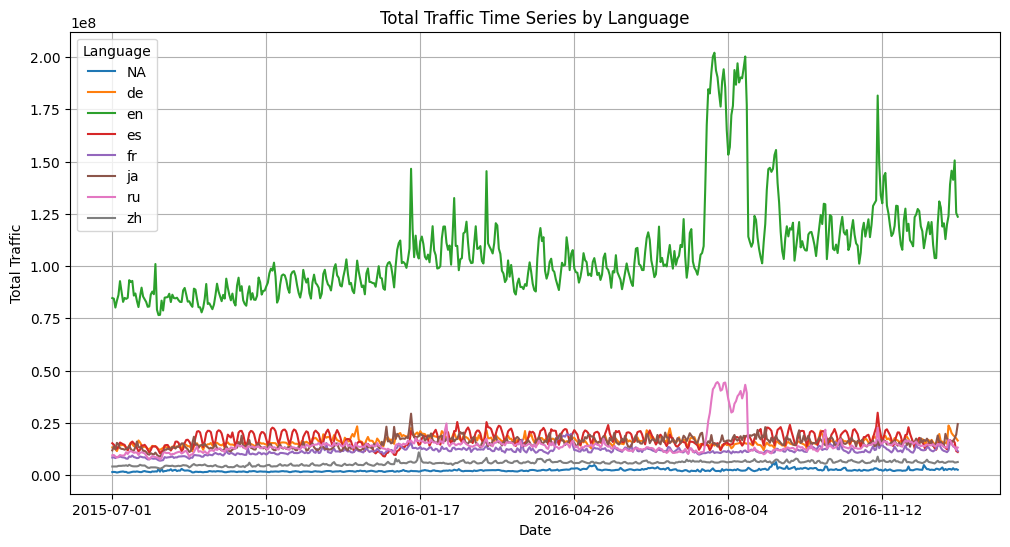

In [29]:
df_language_tot_traffic.plot(figsize=(12, 6))
plt.title('Total Traffic Time Series by Language')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend(title='Language')
plt.grid(True)
plt.show()

Insights:
- Pages in English
- English and Russian show very large spikes around August 2016
  - Maybe due to the Summer Olympics and the election in the US
- Spanish has a periodic cycle 

# Weekdays - Weekend Analysis

In [ ]:
# Extract day of the week
df_melted['day_of_week'] = df_melted['date'].dt.day_name()

# Calculate the average and standard deviation of views for each day of the week
pivot_table_mean = df_melted.pivot_table(values='views', index='day_of_week', aggfunc='mean')

# Reindex to ensure days are in the correct order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table_mean = pivot_table_mean.reindex(days_of_week)

In [ ]:
# Plot the average views with standard deviation as error bars
plt.figure(figsize=(10, 6))
plt.plot(pivot_table_mean.index, pivot_table_mean['views'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Views')
plt.title('Average Views for Each Day of the Week')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

Data visualization in Looker Studio:

In [ ]:
![Weekday analysis](../plots_bigquery/plot_weekday_analysis.png)

Insights:
- More views on Monday and Sunday

# Months Analysis

In [ ]:
df_melted['month'] = df_melted['date'].dt.month_name()

# Use pivot_table to calculate the average and standard deviation of views for each month
pivot_table = df_melted.pivot_table(values='views', index='month', aggfunc='mean')

# Define the correct order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Reindex to ensure months are in the correct order
pivot_table = pivot_table.reindex(months_order)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pivot_table.index, pivot_table['views'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Views')
plt.title('Average Views per Month')
plt.xticks(rotation=45)
plt.grid(axis='y')

Insights:
- Less during the warmer months, but peak in August due to elections and sports

In [ ]:
# Save
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df.to_csv('../data/processed/train_1_processed.csv', index=False)